In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Scale the inputs in range of (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1

11490434/11490434 [==============================] - 1s 0us/step


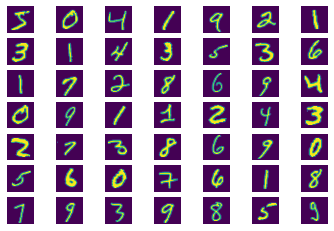

In [3]:
for i in range(49):
  plt.subplot(7, 7, i+1)
  plt.axis("off")
  #plot raw pixel data
  plt.imshow(x_train[i])
plt.show()

In [4]:
N, H, W = x_train.shape  #number, height, width
D = H * W   #dimension (28, 28)
x_train = x_train.reshape(-1, D) 
x_test = x_test.reshape(-1, D)

In [5]:
# Defining Generator Model
latent_dim = 100
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)  #because Image pixel is between -1 to 1.
  model = Model(i, x)  #i is input x is output layer
  return model

In [6]:
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

In [7]:
# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile ( loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
# Build and compile the combined model
generator = build_generator(latent_dim)

In [8]:
## Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))
## Pass noise through a generator to get an Image
img = generator(z)
discriminator.trainable = False
fake_pred = discriminator(img)

In [9]:
combined_model_gen = Model(z, fake_pred)  #first is noise and 2nd is fake prediction
# Compile the combined model
combined_model_gen.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [11]:
batch_size = 32
epochs = 10000
sample_period = 200
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)
#store generator and discriminator loss in each step or each epoch
d_losses = []
g_losses = []
#create a file in which generator will create and save images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')



In [12]:
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)
  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5
  fig, axs = plt.subplots(rows, cols)  #fig to plot img and axis to store
  idx = 0
  for i in range(rows):  #5*5 loop means on page 25 imgs will be there
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [13]:
#FIRST we will train Discriminator(with real imgs and fake imgs)
# Main training loop
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################
  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]  #MNIST dataset
  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)  #generator to generate fake imgs
  fake_imgs = generator.predict(noise)
  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)  #belong to positive class(real imgs)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)  #fake imgs
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  #######################
  ### Train generator ###
  #######################
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)  
  #Now we are trying to fool the discriminator that generate imgs are real that's why we are providing label as 1
  # do it again!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)
  # Save the losses
  d_losses.append(d_loss)  #save the loss at each epoch
  g_losses.append(g_loss)
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f},d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  if epoch % sample_period == 0:
    sample_images(epoch)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
epoch: 5101/10000, d_loss: 0.68,d_acc: 0.48, g_loss: 0.80
1/1 [==============================] - 0s 21ms/step
epoch: 5201/10000, d_loss: 0.68,d_acc: 0.56, g_loss: 0.76
1/1 [==============================] - 0s 23ms/step
epoch: 5301/10000, d_loss: 0.71,d_acc: 0.47, g_loss: 0.79
1/1 [==============================] - 0s 25ms/step
epoch: 5401/10000, d_loss: 0.65,d_acc: 0.61, g_loss: 0.78
1/1 [==============================] - 0s 23ms/step
epoch: 5501/10000, d_loss: 0.69,d_acc: 0.64, g_loss: 0.77
1/1 [==============================] - 0s 23ms/step
epoch: 5601/10000, d_loss: 0.67,d_acc: 0.62, g_loss: 0.77
1/1 [==============================] - 0s 21ms/step
epoch: 5701/10000, d_loss: 0.65,d_acc: 0.58, g_loss: 0.76
1/1 [==============================] - 0s 24ms/step
epoch: 5801/10000, d_loss: 0.72,d_acc: 0.45, g_loss: 0.81
1/1 [==============================] - 0s 24ms/step
epoch: 5901/10000

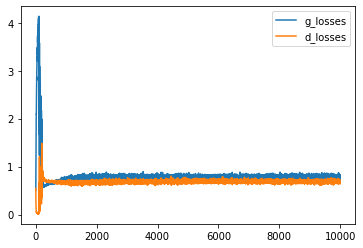

In [15]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()